## Climate data - GSWP3 and COSMO-REA6 vs. VCG temperature observations

started 2023-04-21 from [LSP paper notebook](https://zenodo.org/record/7310652).

This notebook compares temperature forcing from GSWP3 and COSMO-REA6 to observations from the Vestland Climate Grid.

In [1]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import pandas as pd  # Tabular data handling
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path
import urllib.request  
import shutil
import zipfile

#### Load model forcing data

In [2]:
%%bash
pwd

/mnt/c/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/src/analysis_and_plotting


In [4]:
# Define site code and path to climate forcing
site_code = "ALP4"
gswp3_path = Path("../../data/ALP4/datmdata/")
cosmorea6_path = Path("../../data/ALP4_cosmorea_noleap/datmdata/")

In [7]:
# Load netcdf data
start_time = time.time()

gswp3_precipitation = xr.open_mfdataset(
    f'{gswp3_path}/clmforc*Prec.{site_code}*.nc',
    concat_dim='time',
    combine='nested',
    decode_times=True
)

gswp3_temperature = xr.open_mfdataset(
    f'{gswp3_path}/clmforc*TPQWL.{site_code}*.nc',
    concat_dim='time',
    combine='nested',
    decode_times=True
)

cosmo_climate_data = xr.open_mfdataset(
    f'{cosmorea6_path}/*.nc',
    concat_dim='time',
    combine='nested',
    decode_times=True
)

print(f"--- Time it took to read the data: {round(float(time.time() - start_time), 3)} seconds ---")

--- Time it took to read the data: 86.068 seconds ---


## Observation data

In [8]:
# If not already there, download the files
temp_zip_path = Path("../../data/VCG/OSF_VCG/temperature.zip")
temp_unzip_path = Path("../../data/VCG/OSF_VCG/temperature")

obs_data_url = "https://osf.io/download/x5ck9/"

if not temp_zip_path.is_file():
    print("Downloading zip file...", end="")
    with urllib.request.urlopen(obs_data_url) as response, open(temp_zip_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    print("done")
        
# If not already there, unzip csv files
if not temp_unzip_path.is_dir() and temp_zip_path.is_file():
    print("Unzipping...", end="")
    with zipfile.ZipFile(temp_zip_path, 'r') as temp_zip:
        temp_zip.extractall(temp_unzip_path)
    print("done.")

Unzipping...done.


#### Read observation data

In [9]:
obs_temperature_df = pd.read_csv(Path(f"{temp_unzip_path}/VCG_clean_temperature.csv"), low_memory=False)

#### Plot layout and save path settings

In [10]:
# Define folder for saving plots
plot_save_path = Path("../../results/figures/")

if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True, exist_ok=True)

In [11]:
# Set general plotting optionscm = 1/2.54  # centimeters in inches
cm = 1/2.54  # centimeters in inches
DPI = 200
FIG_SIZE_CM = (9.5*cm, 7*cm)
TICK_LABEL_FONT_SIZE = 9
AX_LABEL_FONT_SIZE = 11

In [12]:
obs_temperature_df.head()

,year,date,siteID,logger,value,unit,flag,type,file
0,2008,2008-09-25T16:00:00Z,Alrust,temp200cm,14.41794,°C,NaN,UTL,#001044_20080924_1000_Ålrust.txt
1,2008,2008-09-25T16:00:00Z,Alrust,temp30cm,NaN,°C,NaN,NaN,NaN
2,2008,2008-09-25T16:00:00Z,Alrust,tempsoil,NaN,°C,NaN,NaN,NaN
3,2008,2008-09-25T16:00:00Z,Alrust,tempabove,NaN,°C,NaN,NaN,NaN
4,2008,2008-09-25T16:00:00Z,Arhelleren,temp200cm,NaN,°C,NaN,NaN,NaN


Subset site and 2 m air temperature logger data.

In [15]:
obs_temperature_df["siteID"].unique()

array(['Alrust', 'Arhelleren', 'Fauske', 'Gudmedalen', 'Hogsete',
       'Lavisdalen', 'Ovstedalen', 'Rambera', 'Skjelingahaugen',
       'Ulvehaugen', 'Veskre', 'Vikesland'], dtype=object)

In [16]:
# Site name in observational dataset
site_name_vcg = "Skjelingahaugen"

In [17]:
temperature_df = obs_temperature_df[(obs_temperature_df["siteID"] == site_name_vcg) & (obs_temperature_df["logger"] == "temp200cm")].reset_index(drop=True)
print(f"Shape: {temperature_df.shape}")
print(f"Data types:\n{temperature_df.dtypes}")
temperature_df.head()

Shape: (107528, 9)
Data types:
year        int64
date       object
siteID     object
logger     object
value     float64
unit       object
flag       object
type       object
file       object
dtype: object


,year,date,siteID,logger,value,unit,flag,type,file
0,2008,2008-09-25T16:00:00Z,Skjelingahaugen,temp200cm,NaN,°C,NaN,NaN,NaN
1,2008,2008-09-25T17:00:00Z,Skjelingahaugen,temp200cm,NaN,°C,NaN,NaN,NaN
2,2008,2008-09-25T18:00:00Z,Skjelingahaugen,temp200cm,NaN,°C,NaN,NaN,NaN
3,2008,2008-09-25T19:00:00Z,Skjelingahaugen,temp200cm,NaN,°C,NaN,NaN,NaN
4,2008,2008-09-25T20:00:00Z,Skjelingahaugen,temp200cm,NaN,°C,NaN,NaN,NaN


In [18]:
# Convert date column to datetime, only keep date and value columns
temperature_df['date'] = pd.to_datetime(temperature_df['date'])

temperature_df.drop(labels=['siteID', 'logger', 'flag'], axis=1, inplace=True)

print(f"Data types:\n{temperature_df.dtypes}")
temperature_df.head()

Data types:
year                   int64
date     datetime64[ns, UTC]
value                float64
unit                  object
type                  object
file                  object
dtype: object


,year,date,value,unit,type,file
0,2008,2008-09-25 16:00:00+00:00,NaN,°C,NaN,NaN
1,2008,2008-09-25 17:00:00+00:00,NaN,°C,NaN,NaN
2,2008,2008-09-25 18:00:00+00:00,NaN,°C,NaN,NaN
3,2008,2008-09-25 19:00:00+00:00,NaN,°C,NaN,NaN
4,2008,2008-09-25 20:00:00+00:00,NaN,°C,NaN,NaN


Text(0.5, 1.0, 'Observed 2m temperature')

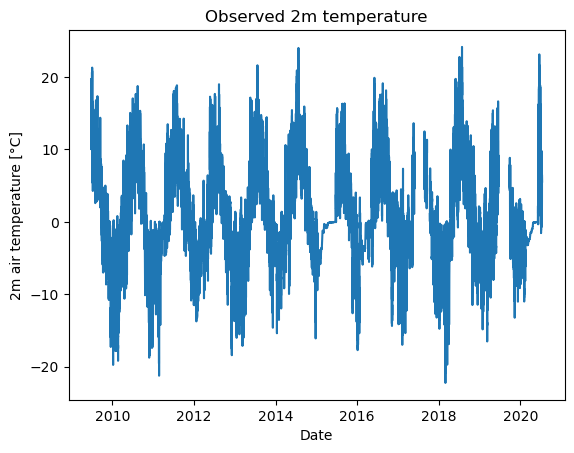

In [20]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(temperature_df['date'], 
        temperature_df['value']
       )
ax.set_xlabel("Date")
ax.set_ylabel("2m air temperature [°C]")
plt.title("Observed 2m temperature")

In [21]:
# Calculate daily mean
obs_temp_daily_mean = temperature_df.groupby(pd.Grouper(key='date', freq='D'))['value'].mean()

<AxesSubplot: xlabel='date'>

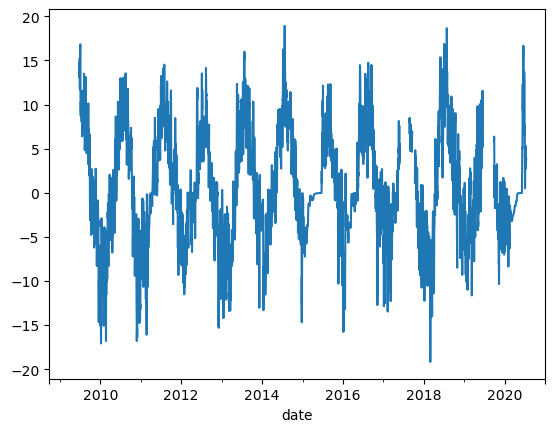

In [22]:
# Quick visualization
obs_temp_daily_mean.plot()

## GSWP3
Load data from xarray Dataset into a pandas DataFrame.

In [25]:
gswp3_df = pd.DataFrame(columns=['date', '2m_temperature', 'precipitation'])

# Subset date, convert to datetime format. Expect a warning due to GSWP3 special NOLEAP calendar format.
gswp3_df['date'] = gswp3_temperature.indexes['time'].to_datetimeindex()

# Subset temperature, convert to deg. C
gswp3_df['2m_temperature'] = gswp3_temperature['TBOT'].values.flatten() - 273.15

# Subset precipitation, convert from [mm H2O / sec] to total (3h=10800s model time step)
gswp3_df['precipitation'] = gswp3_precipitation["PRECTmms"].values.flatten() * 10800

C:\Users\evaler\AppData\Local\Temp\ipykernel_14608\1147756457.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  gswp3_df['date'] = gswp3_temperature.indexes['time'].to_datetimeindex()


In [26]:
gswp3_df.head()

,date,2m_temperature,precipitation
0,1901-01-01 01:30:00,-10.353760,0.0
1,1901-01-01 04:30:00,-9.971039,0.0
2,1901-01-01 07:30:00,-10.259583,0.0
3,1901-01-01 10:30:00,-9.448334,0.0
4,1901-01-01 13:30:00,-8.550842,0.0


Text(0, 0.5, '2m air temperature [°C]')

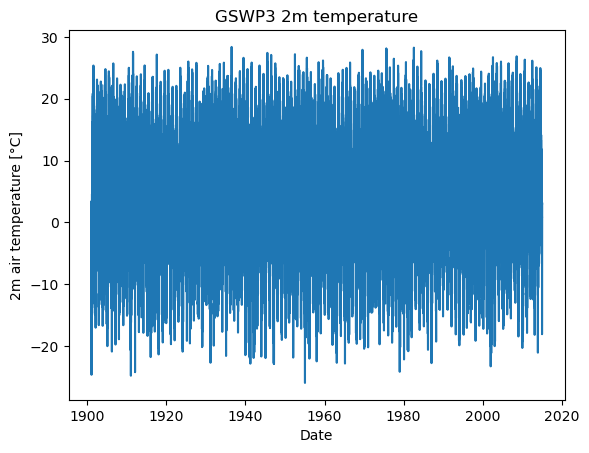

In [27]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(gswp3_df['date'], 
        gswp3_df['2m_temperature']
       )
ax.set_title("GSWP3 2m temperature")
ax.set_xlabel("Date")
ax.set_ylabel("2m air temperature [°C]")

In [28]:
# Calculate daily means
gswp3_daily_temp_df = gswp3_df.groupby(pd.Grouper(key='date', freq='D'))['2m_temperature'].mean()

In [29]:
gswp3_daily_temp_df.head()

date
1901-01-01   -8.617344
1901-01-02   -2.542625
1901-01-03   -0.930363
1901-01-04   -2.063984
1901-01-05   -1.425705
Freq: D, Name: 2m_temperature, dtype: float32

(14245.0, 16436.0)

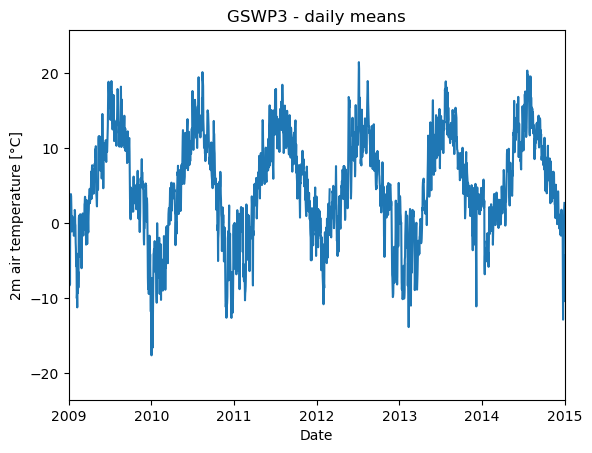

In [30]:
# Quick visualization 
fig, ax = plt.subplots()
ax.plot(gswp3_daily_temp_df.index, 
        gswp3_daily_temp_df.values
       )
ax.set_title("GSWP3 - daily means")
ax.set_xlabel("Date")
ax.set_ylabel("2m air temperature [°C]")
ax.set_xlim(pd.Timestamp(2009, 1, 1), pd.Timestamp(2015, 1, 1))

## COSMO-REA6

Format and get daily means of COSMO-REA6 forcing in the same way as GSWP3

In [34]:
cosmo_df = pd.DataFrame(columns=['date', '2m_temperature', 'precipitation'])

# Subset date, convert to datetime format. Expect a warning due to GSWP3 special NOLEAP calendar format.
cosmo_df['date'] = cosmo_climate_data.indexes['time'].to_datetimeindex()

# Subset temperature, convert to deg. C
cosmo_df['2m_temperature'] = cosmo_climate_data['TBOT'].values.flatten() - 273.15

# Subset precipitation, convert from [mm H2O / sec] to total (3h=10800s model time step)
cosmo_df['precipitation'] = cosmo_climate_data["PRECTmms"].values.flatten() * 10800

C:\Users\evaler\AppData\Local\Temp\ipykernel_14608\2584647288.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cosmo_df['date'] = cosmo_climate_data.indexes['time'].to_datetimeindex()


In [35]:
cosmo_df.head()

,date,2m_temperature,precipitation
0,1995-01-01 01:00:00,-7.497864,0.013215
1,1995-01-01 04:00:00,-7.813873,0.013769
2,1995-01-01 07:00:00,-8.414307,0.000000
3,1995-01-01 10:00:00,-8.705597,0.000000
4,1995-01-01 13:00:00,-7.908081,0.324302


Text(0, 0.5, '2m air temperature [°C]')

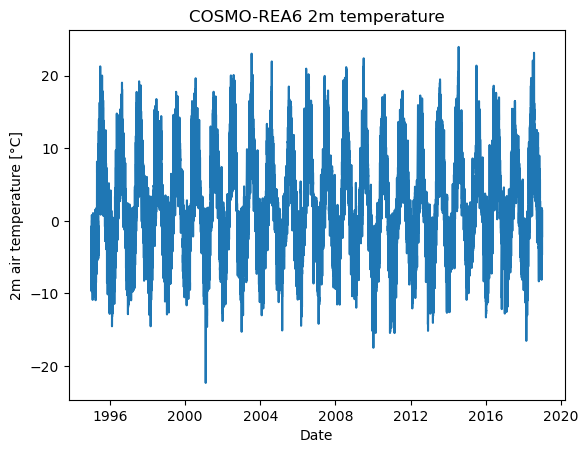

In [38]:
# Quick visualization
fig, ax = plt.subplots()
ax.plot(cosmo_df['date'], 
        cosmo_df['2m_temperature']
       )
ax.set_title("COSMO-REA6 2m temperature")
ax.set_xlabel("Date")
ax.set_ylabel("2m air temperature [°C]")

In [37]:
# Calculate daily means
cosmo_daily_temp_df = cosmo_df.groupby(pd.Grouper(key='date', freq='D'))['2m_temperature'].mean()
cosmo_daily_temp_df.head()

date
1995-01-01   -7.963627
1995-01-02   -8.952522
1995-01-03   -8.154499
1995-01-04   -7.525867
1995-01-05   -6.828323
Freq: D, Name: 2m_temperature, dtype: float32

(14245.0, 16436.0)

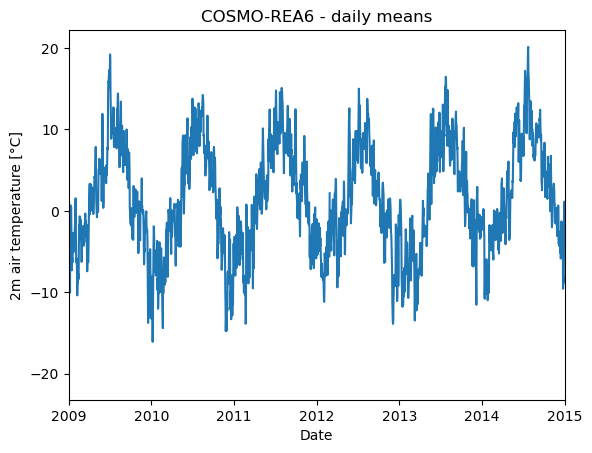

In [39]:
# Quick visualization 
fig, ax = plt.subplots()
ax.plot(cosmo_daily_temp_df.index, 
        cosmo_daily_temp_df.values
       )
ax.set_title("COSMO-REA6 - daily means")
ax.set_xlabel("Date")
ax.set_ylabel("2m air temperature [°C]")
ax.set_xlim(pd.Timestamp(2009, 1, 1), pd.Timestamp(2015, 1, 1))

## Plot data sets together

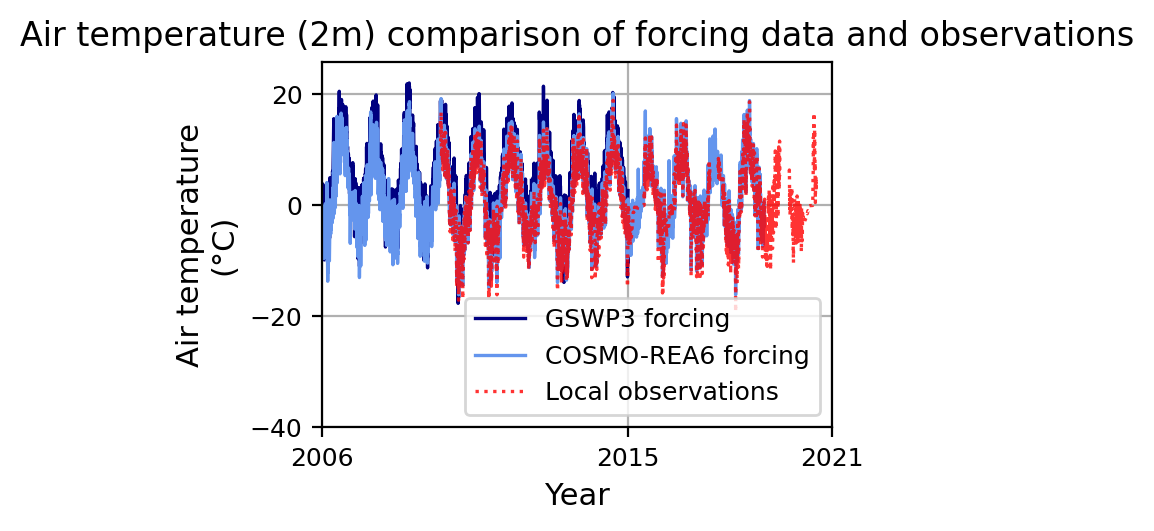

In [45]:
fig, ax = plt.subplots(dpi=DPI, figsize=FIG_SIZE_CM)

# GSWP3
ax.plot(gswp3_daily_temp_df.index, 
        gswp3_daily_temp_df.values,
        linewidth=1.2,
        color="navy",
        label="GSWP3 forcing"
       )

# COSMO-REA6
ax.plot(cosmo_daily_temp_df.index,
        cosmo_daily_temp_df.values,
        linewidth=1.2,
        color="cornflowerblue",
        label="COSMO-REA6 forcing")

# VCG
ax.plot(obs_temp_daily_mean.index, 
        obs_temp_daily_mean.values,
        linewidth=1.2,
        linestyle="dotted",
        alpha=0.8,
        color="red",
        label="Local observations"
       )


ax.set_ylabel("Air temperature\n(°C)", fontsize=AX_LABEL_FONT_SIZE)
ax.set_xlabel("Year", fontsize=AX_LABEL_FONT_SIZE)
ax.set_title("Air temperature (2m) comparison of forcing data and observations")

#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xlim(pd.Timestamp(2006, 1, 1), pd.Timestamp(2021, 1, 1))
ax.set_xticks(
    [pd.Timestamp(2006, 1, 1),
     pd.Timestamp(2015, 1, 1),
     pd.Timestamp(2021, 1, 1)]
)

ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)

import matplotlib.dates as mdates
my_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(my_format)

ax.grid()
ax.legend(fontsize=TICK_LABEL_FONT_SIZE)

# Number of y-ticks
ax.set_yticks([-40, -20, 0, 20])

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/gswp3_vcg_temperatures.png", format='png')

#### Directly compare corresponding values

In [47]:
temp_bias_df = pd.DataFrame(columns=['date', 'vcg_obs'])

# Add values, merge on dates (reset timezone in obs to prevent error)
temp_bias_df['date'] = pd.to_datetime(obs_temp_daily_mean.index).tz_localize(None)
temp_bias_df['vcg_obs'] = obs_temp_daily_mean.values
temp_bias_df = temp_bias_df.join(other=gswp3_daily_temp_df, how='left', on='date')
temp_bias_df = temp_bias_df.join(other=cosmo_daily_temp_df, how='left', on='date', rsuffix='_cosmo')

# Drop rows with missing entries
temp_bias_df = temp_bias_df.dropna(axis=0)
temp_bias_df

,date,vcg_obs,2m_temperature,2m_temperature_cosmo
273,2009-06-25,15.140465,18.721313,15.858467
274,2009-06-26,13.053904,18.842884,15.764050
275,2009-06-27,14.186350,18.820358,16.171188
276,2009-06-28,14.717399,17.770515,16.857216
277,2009-06-29,14.531783,16.349648,17.301437
...,...,...,...,...
2284,2014-12-27,-12.788608,-10.474316,-8.890804
2285,2014-12-28,-7.958681,-3.923279,-8.093338
2286,2014-12-29,-4.113857,0.381527,-3.483124
2287,2014-12-30,-1.210551,2.050442,-0.352127


Linear regression comparison

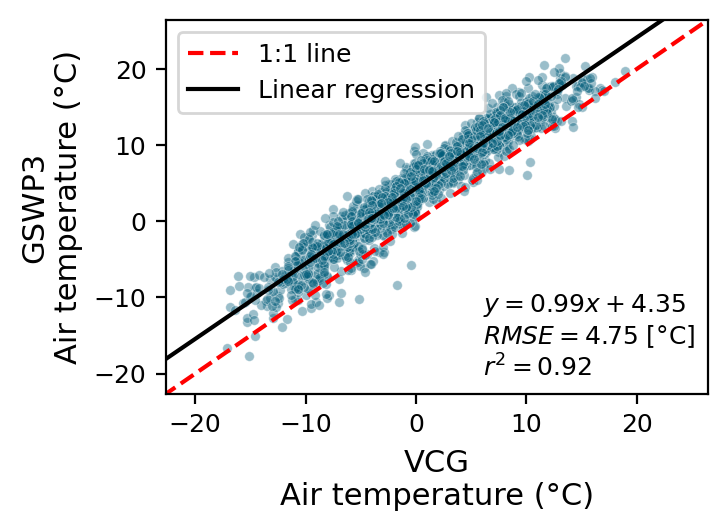

In [33]:
# GSWP3 versus observations
fig, ax = plt.subplots(dpi=DPI, figsize=FIG_SIZE_CM)

ax.scatter(temp_bias_df['vcg_obs'],
           temp_bias_df['2m_temperature'],
           s=12,
           edgecolors='white',
           color="#035e7b",
           linewidth=0.3,
           alpha=0.4
          )

# 1 to 1 line
ax.plot([x+1 for x in range(-40, 40)], 
        [x+1 for x in range(-40, 40)],
        color="red",
        linestyle="--",
        label="1:1 line"
       )

# Linear regression and statistics
import numpy as np
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(temp_bias_df['vcg_obs'],
                                                                     temp_bias_df['2m_temperature']
                                                                    )
plt.axline(xy1=(0, intercept),
           slope=slope, 
           label='Linear regression',
           color='black'
          )

# Calculate root mean square error
rmse = np.sqrt(np.mean(np.square(temp_bias_df['vcg_obs'] - temp_bias_df['2m_temperature'])))

# Add lin. reg. formula and metrics as text to figure
from matplotlib.offsetbox import AnchoredText

text_box = AnchoredText(f'$y = {slope:.2f}x {intercept:+.2f}$\n$RMSE = {rmse:.2f}$ [°C]\n$r^2 = {r_value**2:.2f}$',
                        frameon=False, 
                        loc=4, 
                        pad=0,
                        prop=dict(fontsize=TICK_LABEL_FONT_SIZE)
                       )
# Text box layout
plt.setp(text_box.patch, 
         facecolor='none', 
         alpha=0.5
        )
ax.add_artist(text_box)

# General plot layout
ax.set_xlabel("VCG\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
ax.set_ylabel("GSWP3\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
offset = 5 
ax.set_xlim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature'])]) + offset]
           )
ax.set_ylim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature'])]) + offset]
           )
ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax.legend(fontsize=TICK_LABEL_FONT_SIZE)

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/gswp3_vcg_temperature_bias.png", format='png')

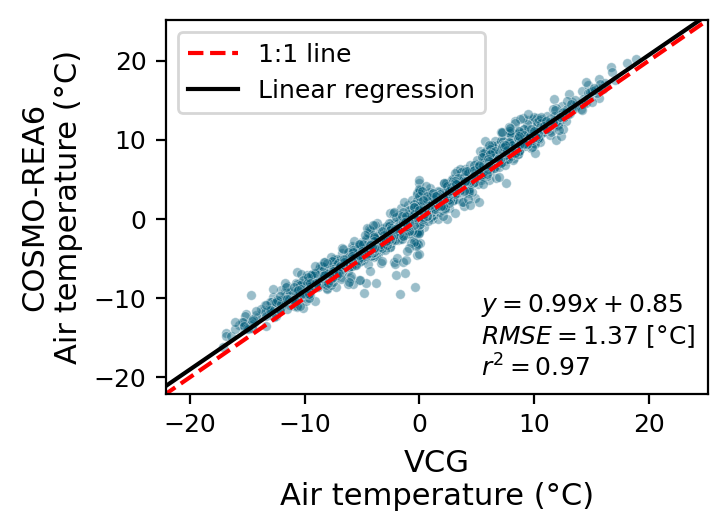

In [48]:
# COSMO-REA6 versus observations
fig, ax = plt.subplots(dpi=DPI, figsize=FIG_SIZE_CM)

ax.scatter(temp_bias_df['vcg_obs'],
           temp_bias_df['2m_temperature_cosmo'],
           s=12,
           edgecolors='white',
           color="#035e7b",
           linewidth=0.3,
           alpha=0.4
          )

# 1 to 1 line
ax.plot([x+1 for x in range(-40, 40)], 
        [x+1 for x in range(-40, 40)],
        color="red",
        linestyle="--",
        label="1:1 line"
       )

# Linear regression and statistics
import numpy as np
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(temp_bias_df['vcg_obs'],
                                                                     temp_bias_df['2m_temperature_cosmo']
                                                                    )
plt.axline(xy1=(0, intercept),
           slope=slope, 
           label='Linear regression',
           color='black'
          )

# Calculate root mean square error
rmse = np.sqrt(np.mean(np.square(temp_bias_df['vcg_obs'] - temp_bias_df['2m_temperature_cosmo'])))

# Add lin. reg. formula and metrics as text to figure
from matplotlib.offsetbox import AnchoredText

text_box = AnchoredText(f'$y = {slope:.2f}x {intercept:+.2f}$\n$RMSE = {rmse:.2f}$ [°C]\n$r^2 = {r_value**2:.2f}$',
                        frameon=False, 
                        loc=4, 
                        pad=0,
                        prop=dict(fontsize=TICK_LABEL_FONT_SIZE)
                       )
# Text box layout
plt.setp(text_box.patch, 
         facecolor='none', 
         alpha=0.5
        )
ax.add_artist(text_box)

# General plot layout
ax.set_xlabel("VCG\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
ax.set_ylabel("COSMO-REA6\nAir temperature (°C)", fontsize=AX_LABEL_FONT_SIZE)
offset = 5 
ax.set_xlim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature_cosmo'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature_cosmo'])]) + offset]
           )
ax.set_ylim([min([min(temp_bias_df['vcg_obs']), min(temp_bias_df['2m_temperature_cosmo'])]) - offset, 
             max([max(temp_bias_df['vcg_obs']), max(temp_bias_df['2m_temperature_cosmo'])]) + offset]
           )
ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax.legend(fontsize=TICK_LABEL_FONT_SIZE)

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/cosmorea6_vcg_temperature_bias.png", format='png')